## TSS alignment midbrain markers

In [2]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import gzip
import loompy
# import scipy.sparse as sparse
import urllib.request
import pybedtools
from pybedtools import BedTool
import warnings
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection
import pickle
from pynndescent import NNDescent

sys.path.append('/home/camiel/chromograph/')
# from chromograph.plotting.UMI_plot import UMI_plot
import chromograph
from chromograph.peak_calling.utils import *
from chromograph.preprocessing.utils import *

import cytograph as cg

from umap import UMAP
import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [61]:
import loompy
import os
import subprocess
import gc
import sys
import numpy as np
from datetime import datetime
import logging
from typing import *
from tqdm import tqdm

import gzip
import glob
import pybedtools
from pybedtools import BedTool
import shutil
import multiprocessing as mp
from pynndescent import NNDescent

## Import chromograph
sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.pipeline.Bin_analysis import *
from chromograph.pipeline import config
from chromograph.pipeline.utils import transfer_ca, div0
from chromograph.features.GA_Aggregator import GA_Aggregator
from chromograph.peak_calling.peak_caller import *
from chromograph.peak_calling.utils import *

## Setup logger and load config
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

class Generate_promoter:
    def __init__(self, outdir) -> None:
        """
        Use Gene reference to generate Gene accessibility scores as a gene expression proxy
        
        Args:
            ds                    Loom connection

        Remarks:
        
        """
        self.config = chromograph.pipeline.config.load_config()
        self.outdir = outdir
        self.peakdir = os.path.join(outdir, 'peaks')
        self.gene_ref = os.path.join(chromograph.__path__[0], 'references/GRCh38_2kbprom.bed')
        self.loom = ''
    
    def fit(self, ds: loompy.LoomConnection) -> None:
        '''
        Use Gene reference to generate Gene accessibility scores as a gene expression proxy
        
        Args:

        Returns:
        
        Remarks:
        
        '''
        ## Get sample name from loom-file
        name = ds.filename.split(".")[0]
        self.loom = os.path.join(self.outdir, f'{name}_prom.loom')

        ## Check if location for peaks and compounded fragments exists
        if not os.path.isdir(self.peakdir):
            os.mkdir(self.peakdir)   

        ## Check All_peaks.loom exists, get subset
        all_prom_loom = os.path.join(self.config.paths.build, 'All', 'All_prom.loom')
        if os.path.exists(all_prom_loom):
            logging.info(f'Main promoter matrix already exists')
            
            with loompy.connect(all_prom_loom) as dsp:
                selection = np.array([x in ds.ca.CellID for x in dsp.ca.CellID])
            
            loompy.combine_faster([all_prom_loom], self.loom, selections=[selection], key = 'ID')
            
            with loompy.connect(self.loom) as ds2:
                transfer_ca(ds, ds2, 'CellID')
            logging.info(f'Finished creating promoter file')
        
        else:
            logging.info(f'Start counting peaks')
            pool = mp.Pool(20, maxtasksperchild=1)
            chunks = np.array_split(ds.ca['CellID'], np.int(np.ceil(ds.shape[1]/1000)))
            for i, cells in enumerate(chunks):
                pool.apply_async(Count_peaks, args=(i, cells, self.config.paths.samples, self.peakdir, self.gene_ref, 'genes', ))
            pool.close()
            pool.join()

            ## Generate row attributes
            row_attrs = {k: [] for k in ['Accession', 'Gene', 'loc', 'BPs']}
            for x in BedTool(self.gene_ref):
                row_attrs['Accession'].append(x.attrs['gene_id'])
                row_attrs['Gene'].append(x.attrs['gene_name'])
                row_attrs['loc'].append(f'{x[0]}:{x[3]}-{x[4]}')
                row_attrs['BPs'].append(int(abs(int(x[3])-int(x[4]))))

            r_dict = {k: v for v,k in enumerate(row_attrs['Accession'])} 

            logging.info("Generating Sparse matrix")
            col = []
            row = []
            v = []

            cix = 0
            IDs = []
            dict_files = glob.glob(os.path.join(self.peakdir, '*.pkl'))
            for file in dict_files:
                Counts = pkl.load(open(file, 'rb'))
                for cell in Counts:
                    if len(Counts[cell]) > 0:
                        for key in (Counts[cell]):
                            col.append(cix)
                            row.append(r_dict[key])
                            v.append(np.int8(Counts[cell][key]))
                        cix+=1
                        IDs.append(cell)
            logging.info(f'CellID order is maintained: {np.array_equal(ds.ca.CellID, np.array(IDs))}')
            matrix = sparse.coo_matrix((v, (row,col)), shape=(len(r_dict.keys()), len(ds.ca['CellID']))).tocsc()
            logging.info(f'Matrix has shape {matrix.shape} with {matrix.nnz} elements')

            ## Create loomfile
            logging.info("Constructing loomfile")
            loompy.create(filename=self.loom, 
                        layers=matrix, 
                        row_attrs=row_attrs, 
                        col_attrs={'CellID': np.array(IDs)},
                        file_attrs=dict(ds.attrs))
            logging.info(f'Transferring column attributes')
            with loompy.connect(self.loom) as ds2:
                transfer_ca(ds, ds2, 'CellID')
            logging.info(f'Loom peaks file saved as {self.loom}')

            for file in glob.glob(os.path.join(self.peakdir, '*.pkl')):
                os.system(f'rm {file}')

            ## Clean up stranded pybedtools tmp files
            pybedtools.helpers.cleanup(verbose=True, remove_all=True)
            return self.loom
    
        ## Generate pooled layer
        with loompy.connect(self.loom) as ds:
            ## Poisson pooling
            logging.info(f"Poisson pooling")
            if 'HPF' in ds.ca:
                decomp = ds.ca.HPF
            elif 'LSI' in ds.ca:
                decomp = ds.ca.LSI
            nn = NNDescent(data=decomp, metric="euclidean")
            indices, distances = nn.query(ds.ca.LSI, k=self.config.params.k_pooling)
            # Note: we convert distances to similarities here, to support Poisson smoothing below
            knn = sparse.csr_matrix(
                (np.ravel(distances), np.ravel(indices), np.arange(0, distances.shape[0] * distances.shape[1] + 1, distances.shape[1])), (decomp.shape[0], decomp.shape[0]))
            max_d = knn.data.max()
            knn.data = (max_d - knn.data) / max_d
            knn.setdiag(1)  # This causes a sparse efficiency warning, but it's not a slow step relative to everything else
            knn = knn.astype("bool")

            ## Start pooling over the network
            ds["pooled"] = 'int32'
            for (_, indexes, view) in ds.scan(axis=0, layers=[""], what=["layers"]):
                ds["pooled"][indexes.min(): indexes.max() + 1, :] = view[:, :] @ knn.T

            logging.info(f'Converting to CPM')  # divide by GA_colsum/1e6
            
            ds.ca['GA_colsum'] = ds[''].map([np.sum], axis=1)[0]
            ds.ca['GA_pooled_colsum'] = ds['pooled'].map([np.sum], axis=1)[0]
            
            ds['CPM'] = 'float32'
            ds['pooled_CPM'] = 'float32'
            progress = tqdm(total = ds.shape[1])
            for (ix, selection, view) in ds.scan(axis=1, batch_size=self.config.params.batch_size):
                ds['CPM'][:,selection] = div0(view[''][:,:], 1e-6 * ds.ca['GA_colsum'][selection])
                ds['pooled_CPM'][:,selection] = div0(view['pooled'][:,:], 1e-6 * ds.ca['GA_pooled_colsum'][selection])
                progress.update(self.config.params.batch_size)
            progress.close()
            
        return self.loom

In [91]:
f = '/proj/DEV_ATAC/PBMC_20200825/All/All.loom'

with loompy.connect(f) as ds:
    cells = np.array_split(ds.ca['CellID'], np.int(np.ceil(ds.shape[1]/1000)))[0]
    Count_peaks(0, cells, '/data/proj/scATAC/samples/', '/proj/DEV_ATAC/PBMC_20200825/All/peaks', '/home/camiel/chromograph/chromograph/references/GRCh38_2kbprom_test.bed')

TypeError: Count_peaks() takes 4 positional arguments but 5 were given

In [22]:
from pybedtools import BedTool
prom = BedTool('/home/camiel/chromograph/chromograph/references/GRCh38_2kbprom.bed')
cBed = BedTool('/data/proj/scATAC/samples/10XPBMC/fragments/AGTCAACAGACAGCTG-1.tsv.gz')

pks = prom.intersect(cBed, wa=True, wb=True)

cDict = {}
## Extract peak_IDs
for line in pks:
    cDict[line.attrs['gene_id']] = 1
    
from collections import Counter
Counter([v for k, v in cDict.items()])

Counter({1: 2855})

(array([7.685e+03, 0.000e+00, 0.000e+00, 4.499e+03, 0.000e+00, 0.000e+00,
        2.897e+03, 2.106e+03, 0.000e+00, 1.635e+03, 2.413e+03, 1.054e+03,
        1.971e+03, 2.326e+03, 2.551e+03, 3.315e+03, 2.359e+03, 2.035e+03,
        1.302e+03, 7.080e+02, 4.300e+02, 1.760e+02, 9.500e+01, 2.600e+01,
        1.200e+01, 1.100e+01, 3.000e+00, 0.000e+00, 1.000e+00, 2.000e+00]),
 array([2.30319606, 2.38018302, 2.45716999, 2.53415696, 2.61114392,
        2.68813089, 2.76511785, 2.84210482, 2.91909179, 2.99607875,
        3.07306572, 3.15005268, 3.22703965, 3.30402662, 3.38101358,
        3.45800055, 3.53498752, 3.61197448, 3.68896145, 3.76594841,
        3.84293538, 3.91992235, 3.99690931, 4.07389628, 4.15088324,
        4.22787021, 4.30485718, 4.38184414, 4.45883111, 4.53581808,
        4.61280504]),
 <a list of 30 Patch objects>)

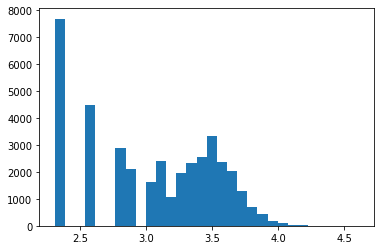

In [15]:
ref = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/'
tss = BedTool(os.path.join(ref, 'regions', 'tss.bed'))
promoter = BedTool(os.path.join(ref, 'regions', 'promoter.bed'))

X = []

for t in promoter:
    X.append(abs(int(t[2]) - int(t[1])))
X = np.array(X)
    
plt.hist(np.log10(X+1), bins=30)

In [127]:
genes = BedTool(os.path.join(ref, 'genes', 'genes.gtf'))

gb = []
for x in genes:
    if x.attrs['gene_type'] == 'protein_coding':
        gb.append(x[2])
print(np.unique(gb))

gb = []
for x in genes:
    if np.logical_and(x[2] == 'gene', x.attrs['gene_type'] == 'protein_coding'):
        gb.append(x)
        
gb = BedTool(gb)
print(gb.count())
flank = gb.flank(genome='hg38', l=2000, r=0, s=True)
flank = flank.slop(genome='hg38', s=True, l=0, r=1000)
flank.head()

['CDS' 'Selenocysteine' 'UTR' 'exon' 'gene' 'start_codon' 'stop_codon'
 'transcript']
19901
chr1	HAVANA	gene	63419	66418	.	+	.	gene_id "ENSG00000186092.6";gene_type "protein_coding";gene_name "OR4F5";level 2;havana_gene "OTTHUMG00000001094.4";
 chr1	HAVANA	gene	450698	453697	.	-	.	gene_id "ENSG00000284733.1";gene_type "protein_coding";gene_name "OR4F29";level 2;tag "overlapping_locus";havana_gene "OTTHUMG00000002860.3";
 chr1	HAVANA	gene	685674	688673	.	-	.	gene_id "ENSG00000284662.1";gene_type "protein_coding";gene_name "OR4F16";level 2;tag "overlapping_locus";havana_gene "OTTHUMG00000002581.3";
 chr1	HAVANA	gene	921928	924927	.	+	.	gene_id "ENSG00000187634.11";gene_type "protein_coding";gene_name "SAMD11";level 2;havana_gene "OTTHUMG00000040719.10";
 chr1	HAVANA	gene	958310	961309	.	-	.	gene_id "ENSG00000188976.10";gene_type "protein_coding";gene_name "NOC2L";level 2;havana_gene "OTTHUMG00000040720.1";
 chr1	HAVANA	gene	958587	961586	.	+	.	gene_id "ENSG00000187961.13";gene_type "prot

In [128]:
flank.bed6().saveas('/home/camiel/chromograph/chromograph/references/GRCh38_2kbprom_test.bed')
flank.saveas('/home/camiel/chromograph/chromograph/references/GRCh38_2kbprom.bed')


<BedTool(/home/camiel/chromograph/chromograph/references/GRCh38_2kbprom.bed)>

In [129]:
import numpy as np
import os
import sys
import pybedtools
from pybedtools import BedTool
import collections
import csv
import matplotlib.pyplot as plt
import gzip
import loompy
import scipy.sparse as sparse
import json
import urllib.request
import logging
import pickle
import importlib

sys.path.append('/home/camiel/chromograph/')
from chromograph.pipeline import config
from chromograph.preprocessing.utils import *
from chromograph.features.feature_count import *
from chromograph.preprocessing.doublet_finder import doublet_finder

ff = '/data/proj/tumor/Healthy_tissues_scATAC/10XPBMC/cellranger/10XPBMC/' + '/outs/fragments.tsv.gz'

logging.info('## Start generating Gene Acessibility Scores ##')
fragments = BedTool(ff)

## Saving fragments in cells

logging.info('Load Genomic regions from reference')
gb = BedTool(os.path.join(chromograph.__path__[0], 'references/GRCh38_2kbprom.bed')).saveas()

logging.info('Intersecting fragments with Genomic regions')
inter = gb.intersect(fragments, wa=True, wb=True)

logging.info('Count promoter overlapping reads per barcode')
Count_dict = Count_genes(meta['barcode'], inter)

logging.info('Reorder data and generate sparse matrix')
r_dict = {k: [] for k in ['Accession', 'Gene', 'loc', 'BPs']}
for x in gb:
    r_dict['Accession'].append(x.attrs['gene_id'])
    r_dict['Gene'].append(x.attrs['gene_name'])
    r_dict['loc'].append(f'{x[0]}:{x[3]}-{x[4]}')
    r_dict['BPs'].append(int(abs(int(x[3])-int(x[4]))))

g_dict = {k: v for v,k in enumerate(r_dict['Accession'])}

## Create sparse matrix
col = []
row = []
v = []

cix = 0
for cell in meta['barcode']:

    for key in (Count_dict[cell]):
        col.append(cix)
        row.append(g_dict[key])
        v.append(float(Count_dict[cell][key]))
    cix+=1

matrix = sparse.coo_matrix((v, (row,col)), shape=(len(g_dict.keys()), len(meta['barcode']))).tocsr()
logging.info(f'Shape matrix: {matrix.shape}. Number of elements: {matrix.nnz}')

18:52:35 INFO     ## Start generating Gene Acessibility Scores ##
18:52:35 INFO     Load Genomic regions from reference
18:52:35 INFO     Intersecting fragments with Genomic regions
18:57:13 INFO     Count promoter overlapping reads per barcode
19:00:44 INFO     Counted 10.0 million Fragments
19:04:16 INFO     Counted 20.0 million Fragments
19:07:50 INFO     Counted 30.0 million Fragments
19:11:26 INFO     Counted 40.0 million Fragments
19:15:02 INFO     Counted 50.0 million Fragments
19:17:48 INFO     Reorder data and generate sparse matrix
19:18:20 INFO     Shape matrix: (19901, 8619). Number of elements: 33974274


In [130]:
## Create loomfile
logging.info("Constructing loomfile")
floom = '/proj/DEV_ATAC/PBMC_20200825/All/All_prom.loom'

with loompy.connect(f, 'r') as ds:

    loompy.create(filename=floom, 
                  layers=matrix, 
                  row_attrs=r_dict, 
                  col_attrs=meta,
                  file_attrs=ds.attrs)

    logging.info("Loom gene file saved as {}".format(floom))

19:18:20 INFO     Constructing loomfile
19:18:31 INFO     Loom gene file saved as /proj/DEV_ATAC/PBMC_20200825/All/All_prom.loom


In [80]:
from chromograph.pipeline.utils import transfer_ca
fpeaks = '/proj/DEV_ATAC/PBMC_20200825/All/All_peaks.loom'

with loompy.connect(fpeaks, 'r') as ds:
    with loompy.connect(floom) as dsb:
        dsb.ca.CellID = [f'10XPBMC:{x}' for x in ds.ca.barcode]
        transfer_ca(ds, dsb, 'CellID')

12:00:54 INFO     Datasets already ordered


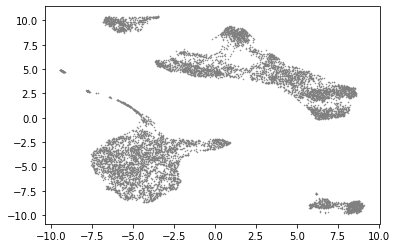

In [154]:
f = '/proj/DEV_ATAC/PBMC_20200825_TFIDF_pooled/All/All_peaks.loom'

with loompy.connect(f) as ds:
    plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c='gray', s=1,  marker='.')

In [157]:
import umap
?UMAP.fit_transform

Signature: UMAP.fit_transform(self, X, y=None)
Docstring:
Fit X into an embedded space and return that transformed
output.

Parameters
----------
X : array, shape (n_samples, n_features) or (n_samples, n_samples)
    If the metric is 'precomputed' X must be a square distance
    matrix. Otherwise it contains a sample per row.

y : array, shape (n_samples)
    A target array for supervised dimension reduction. How this is
    handled is determined by parameters UMAP was instantiated with.
    The relevant attributes are ``target_metric`` and
    ``target_metric_kwds``.

Returns
-------
X_new : array, shape (n_samples, n_components)
    Embedding of the training data in low-dimensional space.
File:      ~/anaconda3/envs/chromo/lib/python3.7/site-packages/umap/umap_.py
Type:      function


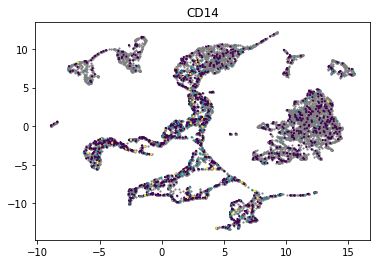

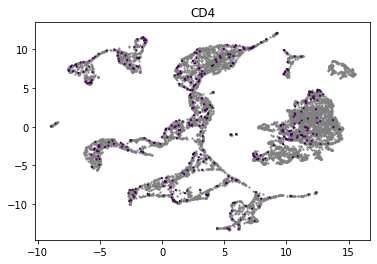

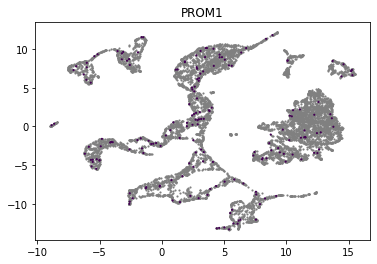

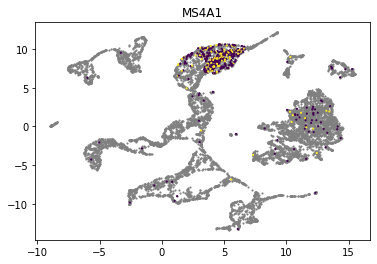

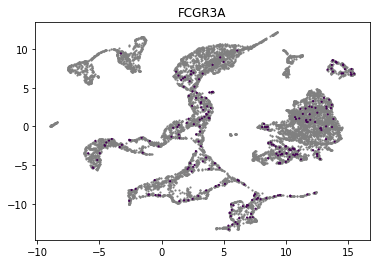

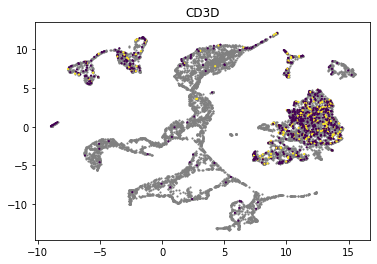

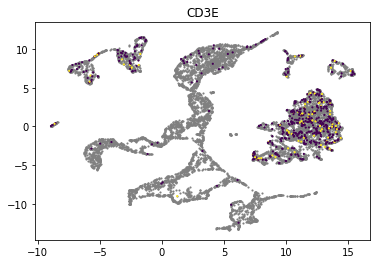

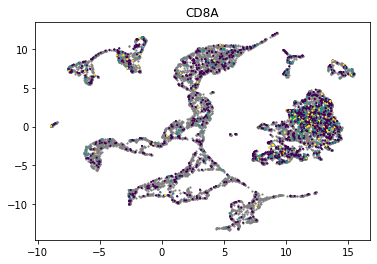

In [132]:
gene = ['CD14', 'CD4', 'PROM1', 'MS4A1', 'FCGR3A', 'CD3D', 'CD3E', 'CD8A']

with loompy.connect(floom) as ds:
    for g in gene:
        X = ds.layers[''][ds.ra.Gene==g,:].flatten()
        plt.figure()
        plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c='gray', s=5,  marker='.', vmax=np.quantile(X,0.99))
        plt.scatter(ds.ca.UMAP[X>0,0], ds.ca.UMAP[X>0,1], c=X[X>0], s=5,  marker='.', vmax=max([np.quantile(X,0.99), 1]))
        plt.title(g)

In [85]:
gb = BedTool(os.path.join(chromograph.__path__[0], 'references/GRCh38_2kbprom.bed')).saveas()

genes = [x.a]

chr1	HAVANA	gene	63419	66418	.	+	.	gene_id "ENSG00000186092.6";gene_type "protein_coding";gene_name "OR4F5";level 2;havana_gene "OTTHUMG00000001094.4";
 chr1	HAVANA	gene	450698	453697	.	-	.	gene_id "ENSG00000284733.1";gene_type "protein_coding";gene_name "OR4F29";level 2;tag "overlapping_locus";havana_gene "OTTHUMG00000002860.3";
 chr1	HAVANA	gene	685674	688673	.	-	.	gene_id "ENSG00000284662.1";gene_type "protein_coding";gene_name "OR4F16";level 2;tag "overlapping_locus";havana_gene "OTTHUMG00000002581.3";
 chr1	HAVANA	gene	921928	924927	.	+	.	gene_id "ENSG00000187634.11";gene_type "protein_coding";gene_name "SAMD11";level 2;havana_gene "OTTHUMG00000040719.10";
 chr1	HAVANA	gene	958310	961309	.	-	.	gene_id "ENSG00000188976.10";gene_type "protein_coding";gene_name "NOC2L";level 2;havana_gene "OTTHUMG00000040720.1";
 chr1	HAVANA	gene	958587	961586	.	+	.	gene_id "ENSG00000187961.13";gene_type "protein_coding";gene_name "KLHL17";level 2;havana_gene "OTTHUMG00000040721.6";
 chr1	HAVANA	gene

In [68]:
floom = '/proj/DEV_ATAC/PBMC_20200825_TFIDF/All/All_prom.loom'
with loompy.connect(floom) as ds:

    ## Poisson pooling
    logging.info(f"Poisson pooling")
    if 'LSI' in ds.ca:
        decomp = ds.ca.LSI
        print('LSI')
    elif 'PCA' in ds.ca:
        decomp = ds.ca.PCA
        print('PCA')
    nn = NNDescent(data=decomp, metric="euclidean", n_neighbors=10, n_jobs=1)
    print(np.sum(nn.neighbor_graph[0]==-1))
    indices, distances = [x.copy() for x in nn.neighbor_graph]
    print(np.sum(nn.neighbor_graph[0]==-1))
    indices2, distances2 = nn.query(decomp)
    print(np.sum(nn.neighbor_graph[0]==-1))
    # Note: we convert distances to similarities here, to support Poisson smoothing below
    knn = sparse.csr_matrix(
        (np.ravel(distances), np.ravel(indices), np.arange(0, distances.shape[0] * distances.shape[1] + 1, distances.shape[1])), (decomp.shape[0], decomp.shape[0]))
    max_d = knn.data.max()
    knn.data = (max_d - knn.data) / max_d
    knn.setdiag(1)  # This causes a sparse efficiency warning, but it's not a slow step relative to everything else
    knn = knn.astype("bool")

    ## Start pooling over the network
    logging.info(f'Start pooling')
    ds["pooled"] = 'int32'
    for (_, indexes, view) in ds.scan(axis=0, layers=[""], what=["layers"]):
        ds["pooled"][indexes.min(): indexes.max() + 1, :] = view[:, :] @ knn.T
        
    print(indices)
    print(indices2)

16:18:20 INFO     Poisson pooling


LSI
0
0


16:18:21 INFO     Start pooling


43433
[[   0  129  259 ...  242  176  130]
 [   1  294  276 ...  182  280   72]
 [   2  306    0 ...  125  182  102]
 ...
 [8616 8094 8111 ... 8489 8402 8212]
 [8617 8155 8359 ... 8441 8308 8150]
 [8618 8554 8437 ... 8348 8347 8338]]
[[   0  129  259 ...  242  176  130]
 [   1  294  276 ...  182  280   72]
 [   2  306    0 ...  125  182  102]
 ...
 [8616 8094 8111 ... 8489 8212 8299]
 [8617 8155 8359 ... 8441 8308 8150]
 [8618 8554 8437 ... 8348 8347 8338]]


In [86]:
floom = '/proj/DEV_ATAC/PBMC_20200825_TFIDF_pooled/All/All_prom.loom'
with loompy.connect(floom) as ds:

    ## Poisson pooling
    logging.info(f"Poisson pooling")
    if 'LSI' in ds.ca:
        decomp = ds.ca.LSI
        print('LSI')
    elif 'PCA' in ds.ca:
        decomp = ds.ca.PCA
        print('PCA')
    nn = NNDescent(data=decomp, metric="euclidean", n_neighbors=10, n_jobs=1, verbose=True)
    indices, distances = [x.copy() for x in nn.neighbor_graph]
    print(indices)

17:49:56 INFO     Poisson pooling


LSI
Thu Sep  3 17:49:56 2020 Building RP forest with 10 trees
Thu Sep  3 17:49:56 2020 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
[[   0  183   26 ...  192  257   13]
 [   1   36  230 ...  186   13  232]
 [   2  152   74 ...  100  118  181]
 ...
 [8616 8591 8609 ... 8583 8538 8598]
 [8617 8579 8588 ... 8591 8545 8594]
 [8618 8552 8554 ... 8582 8551 8573]]


In [72]:
X = scipy.sparse.csr_matrix(np.random.randn(10000,1247)>3)

nn = NNDescent(data=X, metric="euclidean", n_neighbors=10)
indices, distances = nn.neighbor_graph
np.sum(nn.neighbor_graph[0]==-1)

0

In [73]:
Y = scipy.sparse.csr_matrix(np.random.randn(500,1247)>3)


indices2, distances2 = nn.query(Y)
np.sum(nn.neighbor_graph[0]==-1)

/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


62531

In [84]:
?NNDescent

Init signature:
NNDescent(
    data,
    metric='euclidean',
    metric_kwds=None,
    n_neighbors=15,
    n_trees=None,
    leaf_size=None,
    pruning_degree_multiplier=2.0,
    diversify_epsilon=1.0,
    n_search_trees=1,
    tree_init=True,
    random_state=None,
    algorithm='standard',
    low_memory=False,
    max_candidates=None,
    n_iters=None,
    delta=0.001,
    n_jobs=None,
    compressed=False,
    seed_per_row=False,
    verbose=False,
)
Docstring:     
NNDescent for fast approximate nearest neighbor queries. NNDescent is
very flexible and supports a wide variety of distances, including
non-metric distances. NNDescent also scales well against high dimensional
graph_data in many cases. This implementation provides a straightfoward
interface, with access to some tuning parameters.

Parameters
----------
data: array os shape (n_samples, n_features)
    The training graph_data set to find nearest neighbors in.

metric: string or callable (optional, default='euclidean')
  

In [53]:
print(nn.neighbor_graph[0])
X = nn.neighbor_graph[0].copy()
_, _ = nn.query(decomp)
print(nn.neighbor_graph[0])
print(X)

[[9749 5110  426 ... 8754 8626 9140]
 [   1 7973  442 ... 3220 5400   -1]
 [   2 4008 2843 ... 7895 5129   -1]
 ...
 [9997 7470 6102 ... 3027 2553 6627]
 [9998  821  492 ... 1759 5430   -1]
 [9999 1276  677 ... 1107 1752 4071]]
[[9749 5110  426 ... 8754 8626 9140]
 [   1 7973  442 ... 3220 5400   -1]
 [   2 4008 2843 ... 7895 5129   -1]
 ...
 [9997 7470 6102 ... 3027 2553 6627]
 [9998  821  492 ... 1759 5430   -1]
 [9999 1276  677 ... 1107 1752 4071]]
[[9749 5110  426 ... 8754 8626 9140]
 [   1 7973  442 ... 3220 5400   -1]
 [   2 4008 2843 ... 7895 5129   -1]
 ...
 [9997 7470 6102 ... 3027 2553 6627]
 [9998  821  492 ... 1759 5430   -1]
 [9999 1276  677 ... 1107 1752 4071]]


In [83]:
f = '/proj/DEV_ATAC/PBMC_20200825_TFIDF_pooled/All/All_peaks2.loom'

with loompy.connect(f) as ds:
#     ds.ca.LSI_b = ds.ca.LSI
    print(ds.ca.keys())

['Age', 'All_fc_analysis_id', 'Analysis', 'Bplength', 'Cdnalibcomment', 'Cdnalibok', 'CellID', 'Cellconc', 'Chemistry', 'Clusterdensity', 'Clusterpf', 'Clusters', 'ClustersModularity', 'ClustersSurprise', 'Comment', 'DNase_sensitive_region_fragments', 'Datecaptured', 'Dateseqlib', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'Finalconc', 'Id', 'Idxset', 'Inputmrna', 'LSI', 'LSI_b', 'Label', 'Method', 'Molarity', 'NBins', 'NPeaks', 'Name', 'Neuronprop', 'Ngperulcdna', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersSurprise', 'PCA', 'Pcrcycles', 'Plugdate', 'Project', 'Read1specificseq', 'Roi', 'Sampleok', 'Seqcomment', 'Seqlibcomment', 'Seqlibok', 'Sex', 'Shearing', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSS_fragments', 'Targetnumcells', 'Tissue', 'Totcells', 'Totreads', 'Transcriptome', 'UMAP', 'UMAP3D', 'barcode', 'blacklist_region_fragments', 'cell_id', 'chimeric', 'duplicate', 'enhancer_region_fragments', 'is__cell_barcode', 'lowmapq', 

In [59]:
floom = '/proj/DEV_ATAC/PBMC_20200825/All/All_peaks.loom'
with loompy.connect(floom) as ds:
    
    temporary_aggregate = '/proj/DEV_ATAC/PBMC_20200825/tmp.loom'
    ds.aggregate(temporary_aggregate, None, "Clusters", "sum", {"Clusters": "first"})    

16:08:28 INFO     Convert to CPMs
16:08:28 INFO     Calculating variance
16:08:33 INFO     Selecting 20000 peaks for clustering
16:08:40 INFO     Valid peaks: 85655
16:08:40 INFO     Selecting 20000 peaks for clustering
16:08:46 INFO     Valid peaks: 60268
16:08:47 INFO     Selecting 20000 peaks for clustering
16:08:53 INFO     Valid peaks: 30946
16:08:53 INFO     0.7369403795214728
16:08:53 INFO     0.2979848784761657


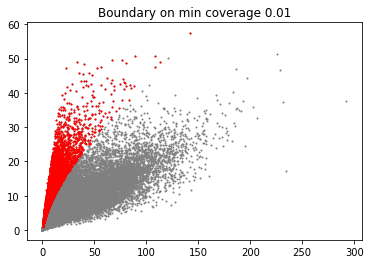

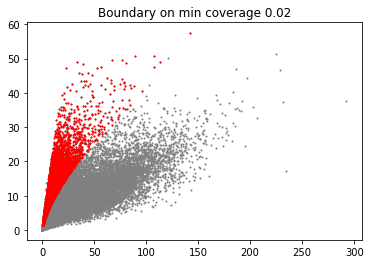

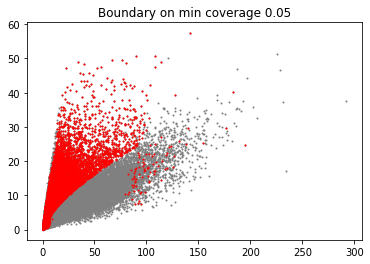

In [62]:
from scipy.spatial.distance import jaccard
from chromograph.peak_analysis.feature_selection_by_variance import FeatureSelectionByVariance

X = 20000
min_f = [0.01, 0.02, 0.05]
q = []
v = []

with loompy.connect(floom) as ds:    
    with loompy.connect(temporary_aggregate) as dsout:
        ## Normalize peak counts by total fragments per cluster
        dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
        logging.info('Convert to CPMs')
        dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)
        logging.info('Calculating variance')
        (mu, sd) = dsout['CPM'].map((np.mean, np.std), axis=0)
        for frac in min_f:
            logging.info(f'Selecting {X} peaks for clustering')
            
            
            dsout.ra.Valid = np.array((ds.ra.NCells / ds.shape[1]) > frac) & (ds.ra.NCells < np.quantile(ds.ra.NCells, 0.99))
            fs = FeatureSelectionByVariance(n_genes=X, layer='CPM')
            v.append(fs.fit(dsout))
            
#             q.append(np.quantile(sd[dsout.ra.Valid==1], 1-(X/np.sum(dsout.ra.Valid))))
#             v.append(np.array((sd > q[-1]) & dsout.ra.Valid==1))

            logging.info(f'Valid peaks: {np.sum(dsout.ra.Valid)}')
    
            plt.figure()
            plt.scatter(mu, sd, s=1, c='gray')
            plt.scatter(mu[v[-1]], sd[v[-1]], s=1, c='red')
            plt.title(f'Boundary on min coverage {frac}')
        
        for i in range(len(v)-1):
            logging.info(1-jaccard(v[0], v[i+1]))
# os.remove(temporary_aggregate)

0.08713307808330432


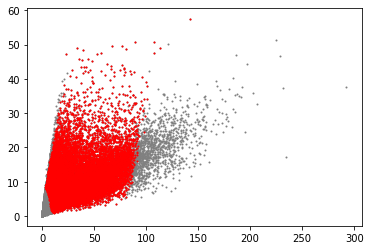

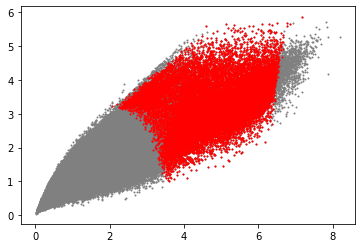

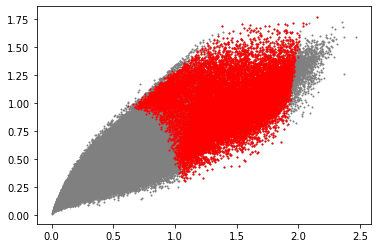

In [65]:
with loompy.connect(floom) as ds:    
    with loompy.connect(temporary_aggregate) as dsout:
        
        q = np.quantile(ds.ra.NCells, 1-(20000/ds.shape[0]))
        print(q/ds.shape[1])
        x = (ds.ra.NCells > q) & (ds.ra.NCells < (ds.shape[1] * 0.5))
        
        plt.figure()
        plt.scatter(mu, sd, s=1, c='gray')
        plt.scatter(mu[x], sd[x], s=1, c='red')
        
        plt.figure()
        plt.scatter(np.log2(mu+1), np.log2(sd+1), s=1, c='gray')
        plt.scatter(np.log2(mu[x]+1), np.log2(sd[x]+1), s=1, c='red')
        
        plt.figure()
        plt.scatter(np.log10(mu+1), np.log10(sd+1), s=1, c='gray')
        plt.scatter(np.log10(mu[x]+1), np.log10(sd[x]+1), s=1, c='red')

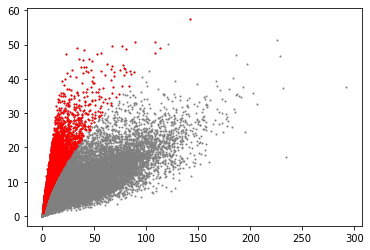

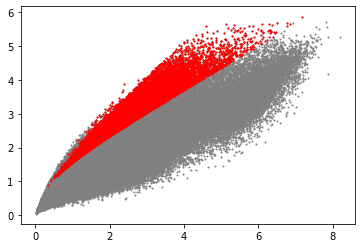

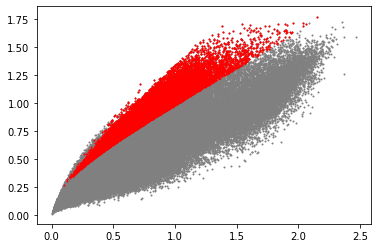

In [66]:
with loompy.connect(floom) as ds:    
    with loompy.connect(temporary_aggregate) as dsout:
        x = v[0]
        
        plt.figure()
        plt.scatter(mu, sd, s=1, c='gray')
        plt.scatter(mu[x], sd[x], s=1, c='red')
        
        plt.figure()
        plt.scatter(np.log2(mu+1), np.log2(sd+1), s=1, c='gray')
        plt.scatter(np.log2(mu[x]+1), np.log2(sd[x]+1), s=1, c='red')
        
        plt.figure()
        plt.scatter(np.log10(mu+1), np.log10(sd+1), s=1, c='gray')
        plt.scatter(np.log10(mu[x]+1), np.log10(sd[x]+1), s=1, c='red')

In [33]:
floom = '/proj/DEV_ATAC/PBMC_20200825/All/All_prom.loom'
with loompy.connect(floom) as ds:
    print(ds.layers.keys())

['', 'pooled']


In [30]:
floom = '/proj/DEV_ATAC/PBMC_20200825/All/All_prom.loom'
fGA = '/proj/DEV_ATAC/PBMC_20200825/All/old_All_GA.loom'
gene = ['CD14', 'CD4', 'PROM1', 'MS4A1', 'FCGR3A', 'CD3D', 'CD3E', 'CD8A']
with loompy.connect(floom) as ds1:
    with loompy.connect(fGA) as ds2:
        print(ds1.layers.keys())
        print(ds1.ca.keys())
#         for g in gene:
#             fig, ax = plt.subplots(1,2)
#             for i, ds in enumerate([ds1, ds2]):
#                 try:
#                     X = ds.layers['pooled'][ds.ra.Gene==g,:].flatten()
#                 except:
#                     X = ds.layers['smooth'][ds.ra.Gene==g,:].flatten()
#                 ax[i].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c='gray', s=5,  marker='.', vmax=np.quantile(X,0.99))
#                 im = ax[i].scatter(ds.ca.TSNE[X>0,0], ds.ca.TSNE[X>0,1], c=X[X>0], s=5,  marker='.', vmax=max([np.quantile(X,0.99), 1]))
#                 fig.colorbar(im, ax=ax[i], orientation='vertical')
#                 ax[i].set_title(g)

['']
['Age', 'All_fc_analysis_id', 'Analysis', 'Bplength', 'Cdnalibcomment', 'Cdnalibok', 'CellID', 'Cellconc', 'Chemistry', 'Clusterdensity', 'Clusterpf', 'Clusters', 'ClustersModularity', 'ClustersModularity_bin', 'ClustersSurprise', 'ClustersSurprise_bin', 'Clusters_bin', 'Comment', 'DNase_sensitive_region_fragments', 'Datecaptured', 'Dateseqlib', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'Enriched_Motifs', 'Finalconc', 'GA_colsum', 'HPF', 'HPF_theta', 'Id', 'Idxset', 'Inputmrna', 'LSI', 'Label', 'Method', 'Molarity', 'NBins', 'NPeaks', 'Name', 'Neuronprop', 'Ngperulcdna', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersModularity_bin', 'OutliersSurprise', 'OutliersSurprise_bin', 'PCA', 'Pcrcycles', 'Plugdate', 'Project', 'Read1specificseq', 'Roi', 'Sampleok', 'Seqcomment', 'Seqlibcomment', 'Seqlibok', 'Sex', 'Shearing', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSNE_bin', 'TSS_fragments', 'Targetnumcells', 'Tissue', 'Totcells', 'Totread

In [37]:
prom = gb = BedTool(os.path.join(chromograph.__path__[0], 'references/GRCh38_2kbprom.bed')).saveas()
peaks = BedTool('/proj/DEV_ATAC/PBMC_20200825_pooled/All/peaks/Compounded_peaks.bed').saveas()

inter = peaks.intersect(prom, wa=True, wb=True)

logging.info(f'prom {prom.count()} peaks: {peaks.count()} inter: {inter.count()}')

10:34:00 INFO     prom 19901 peaks: 142522 inter: 17561


In [83]:
import scipy.sparse as sparse

f_peaks = '/proj/DEV_ATAC/PBMC_20200825/All/All_peaks.loom'
f_new = '/proj/DEV_ATAC/PBMC_20200825/All/test.loom'
D_down = 1000
D_up = -2000

if os.path.exists(f_new):
    os.remove(f_new)

with loompy.connect(f_peaks) as ds:
    V = (ds.ra['Distance to TSS'].astype(int) < D_down) & (ds.ra['Distance to TSS'].astype(int) > D_up)
    G = ds.ra['Gene Name'][V]
    logging.info(f'Peaks {np.sum(V)} for {len(np.unique(G))} genes')
    
    with loompy.new(f_new) as dsout:
        dsout.add_columns({'': sparse.csr_matrix(np.zeros((len(np.unique(G)), ds.shape[1])))}, 
                          col_attrs=ds.ca, 
                          row_attrs={'Gene': np.unique(G)})
        
        for k in np.where(V)[0]:
            g = ds.ra['Gene Name'][k]
            dsout[''][dsout.ra.Gene == g, :] = dsout[''][dsout.ra.Gene == g, :] + ds[''][k,:]
            
            i += 1
            
            if i%1000==0:
                logging.info(i)

12:06:15 INFO     Peaks 26112 for 20487 genes
12:06:48 INFO     1000
12:07:17 INFO     2000
12:07:46 INFO     3000
12:08:15 INFO     4000
12:08:46 INFO     5000
12:09:16 INFO     6000
12:09:47 INFO     7000
12:10:18 INFO     8000
12:10:51 INFO     9000
12:11:23 INFO     10000
12:11:57 INFO     11000
12:12:32 INFO     12000
12:13:10 INFO     13000
12:13:47 INFO     14000
12:14:22 INFO     15000
12:14:56 INFO     16000
12:15:31 INFO     17000
12:16:07 INFO     18000
12:16:42 INFO     19000
12:17:18 INFO     20000
12:17:55 INFO     21000
12:18:33 INFO     22000
12:19:11 INFO     23000
12:19:49 INFO     24000
12:20:28 INFO     25000
12:21:07 INFO     26000


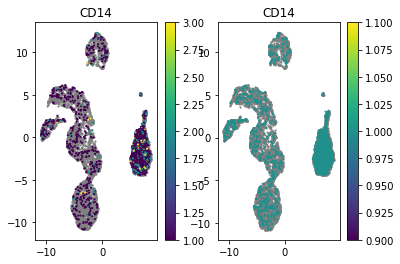

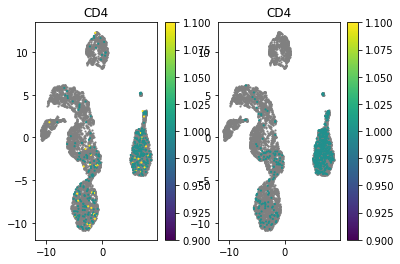

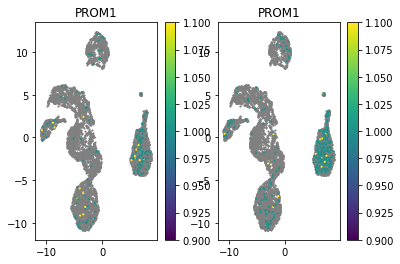

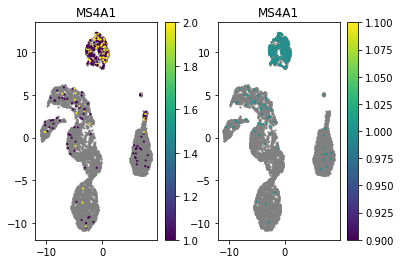

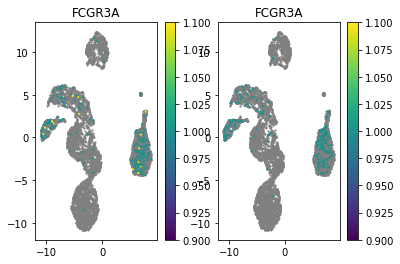

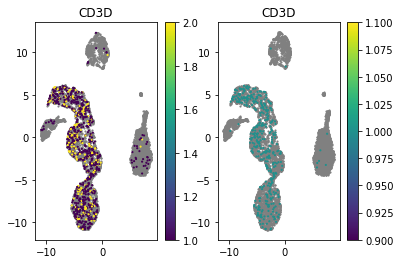

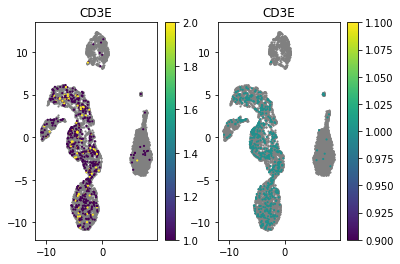

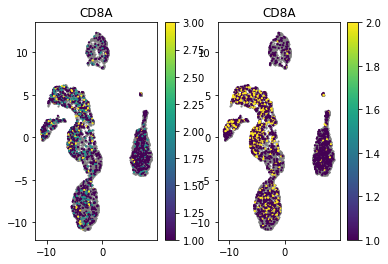

In [87]:
with loompy.connect(floom) as ds1:
    with loompy.connect(f_new) as ds2:
        for g in gene:
            fig, ax = plt.subplots(1,2)
            for i, ds in enumerate([ds1, ds2]):
                try:
                    X = ds.layers[''][ds.ra.Gene==g,:].flatten()
                except:
                    X = ds.layers[''][ds.ra.Gene==g,:].flatten()
                ax[i].scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c='gray', s=5,  marker='.', vmax=np.quantile(X,0.99))
                im = ax[i].scatter(ds.ca.UMAP[X>0,0], ds.ca.UMAP[X>0,1], c=X[X>0], s=5,  marker='.', vmax=max([np.quantile(X,0.99), 1]))
                fig.colorbar(im, ax=ax[i], orientation='vertical')
                ax[i].set_title(g) 

In [2]:
## Import path to the relevant 10X reference dataset

ref = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/'
f_atac = '/data/proj/scATAC/chromograph/build_20191205/Midbrain.loom'
f_agg = '/proj/human_development/emelie_20190912/data/Midbrain.agg.loom'

pybedtools.helpers.set_bedtools_path('/data/bin/bedtools2/bin')

pad = 1000

In [152]:
ds = loompy.connect(f_atac, mode='r')
dsa = loompy.connect(f_agg, mode='r', validate=False)

In [5]:
fa = '/home/camiel/misc/10X232_4.bed'
fb = '/home/camiel/misc/10X232_3.bed'

## Setup BedTool 1
logging.info(f"Setup BedTool 1")
frags = BedTool(fa)
# logging.info(f"Merge with file 2")
## Merge with file2
# frags = a.cat(fb)
logging.info(f"Loaded in total {len(frags)} fragments")

10:42:40 INFO     Setup BedTool 1
10:42:40 INFO     Merge with file 2


223299675

In [7]:
(top_enr,) = dsa['enrichment'].map([np.max], axis=0)
q = 1 - (2000 / dsa.shape[0])
lim = np.quantile(top_enr, q)
logging.info(f"Minimum enrichment: {lim} with {sum(top_enr>lim)} genes")
selected = dsa.ra['Accession', 'Gene'][top_enr>lim,:]

10:55:20 INFO     64.28052619313195 with 2000 genes


In [94]:
sel = np.random.choice(np.arange(dsa.shape[0]), size=2000, replace=False)
Rsel = np.zeros(dsa.shape[0], dtype=int)
Rsel[sel] = 1
Random_genes = dsa.ra['Accession', 'Gene'][Rsel,:]
logging.info(f"Selected 2.000 random background genes")

12:18:50 INFO     Selected 2.000 random background genes


In [106]:
def TSS_enrichment(fragments, selected, pad=2000):
    ## Load TSS sites
    tss = BedTool(os.path.join(ref, 'regions', 'tss.bed'))
    TSS = []
    logging.info(f"Removing TSS not in selection list")
    for x in tss:
        if x[3] in selected:
            TSS.append(x)
    del tss
    TSS = BedTool(TSS)
    logging.info(f"Create padded bedtool")
    TSS_pad = TSS.slop(b=pad, genome = 'hg38')

    ## Filter our fragments not overlapping TSS_pad
    logging.info(f"filter out fragments not overlapping padded area")
    filt = fragments.intersect(TSS_pad)
    logging.info(f"Remaining fragments: {len(filt)}")

    ## Get middle every fragments (mean min/max)
    logging.info(f"Extracting midpoint for all fragments")
    mids = []
    i = 0
    for x in filt:
        st = round((int(x[1]) + int(x[2]))/2)
        end = st + 1
        mids.append([x[0],st, end])
        i += 1
        if i%2000000 == 0:
            logging.info(f"Processed: {i} frags")
    mids = BedTool(mids)

    ## Distance to closest TSS
    logging.info(f"Calculated distancesing")
    dists = mids.sort().closest(TSS.sort(), D='b')

    ## Calculate distances
    logging.info(f"Calculating distances to nearest TSS")
    d = []
    i = 0
    err = []
    for x in dists:
        try:
            d.append(x[10])
        except:
            err.append(x)
        i += 1
        if i%2000000 == 0:
            logging.info(f"Calculated distance for {i} fragments")

    logging.info(f"Sort and return array of TSS enrichment")
    from collections import Counter
    counts = Counter(d)
    pos = []
    for k in counts:
        pos.append((k,counts[k]))
    pos = np.array(pos, dtype=[('dist', int), ('count', float)])
    pos = np.sort(pos, order='dist')

    return pos

logging.info(f"Start processing enriched genes")
pos = TSS_enrichment(frags, selected, pad=pad)
logging.info(f"Start processing background genes")
pos_bg = TSS_enrichment(frags, Random_genes, pad=pad)

13:11:53 INFO     Removing TSS not in selection list
13:12:04 INFO     Create padded bedtool
13:12:04 INFO     filter out fragments not overlapping padded area
13:14:31 INFO     Remaining fragments: 14076449
13:14:31 INFO     Extracting midpoint for all fragments
13:14:38 INFO     1000000
13:14:44 INFO     2000000
13:14:50 INFO     3000000
13:14:57 INFO     4000000
13:15:03 INFO     5000000
13:15:08 INFO     6000000
13:15:15 INFO     7000000
13:15:20 INFO     8000000
13:15:26 INFO     9000000
13:15:32 INFO     10000000
13:15:38 INFO     11000000
13:15:44 INFO     12000000
13:15:49 INFO     13000000
13:15:56 INFO     14000000
13:16:59 INFO     Calculated distancesing
13:17:56 INFO     Calculating distances to nearest TSS
13:18:05 INFO     1000000
13:18:14 INFO     2000000
13:18:22 INFO     3000000
13:18:31 INFO     4000000
13:18:40 INFO     5000000
13:18:48 INFO     6000000
13:18:57 INFO     7000000
13:19:06 INFO     8000000
13:19:14 INFO     9000000
13:19:23 INFO     10000000
13:19:32 

In [118]:
from numpy.lib.recfunctions import append_fields
pos = append_fields(pos, 'fraq', np.zeros(pos.shape[0]))
pos_bg = append_fields(pos_bg, 'fraq', np.zeros(pos_bg.shape[0]))

pos['fraq'] = pos['count']/max(pos['count'])
pos_bg['fraq'] = pos_bg['count']/max(pos_bg['count'])

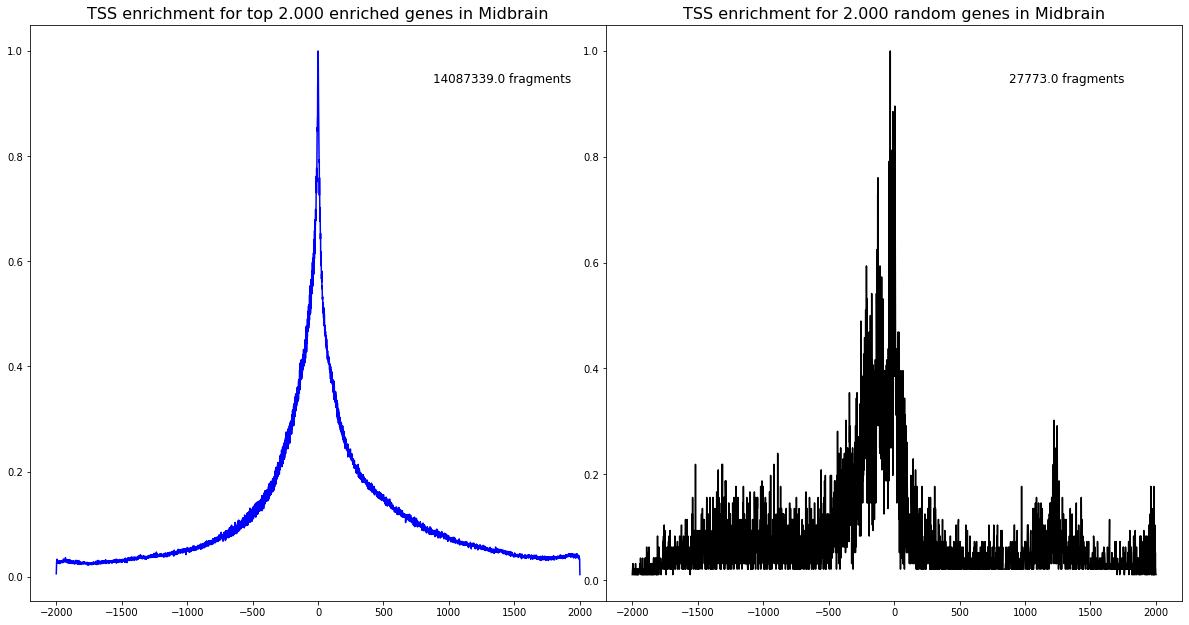

In [149]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_axes([0, 0, 0.5, 1])

ax.plot(pos['dist'], pos['fraq'], c = 'blue')
ax.set_title(f"TSS enrichment for top 2.000 enriched genes in Midbrain", {'fontsize': 16})
ax.text(0.7, 0.9, f"{sum(pos['count'])} fragments", {'fontsize': 12}, transform=ax.transAxes)

ax2 = fig.add_axes([0.5, 0, 0.5, 1])
ax2.plot(pos_bg['dist'], pos_bg['fraq'], c = 'black')
ax2.set_title(f"TSS enrichment for 2.000 random genes in Midbrain", {'fontsize': 16})
ax2.text(0.7, 0.9, f"{sum(pos_bg['count'])} fragments", {'fontsize': 12}, transform=ax2.transAxes)
fig.savefig('/home/camiel/misc/TSS_midbrain_enrichment.png', format="png", dpi=144, bbox_inches='tight')